## Librairies à importer

In [187]:
import numpy as np 
import pandas as pd 
import hvplot.pandas
import re 
from sklearn.metrics import f1_score
from langdetect import detect
from langdetect import detect_langs
from sklearn import preprocessing
from nltk.stem.snowball import EnglishStemmer
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestClassifier
from sklearn import svm
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from wordcloud import WordCloud, STOPWORDS 
import matplotlib.pyplot as plt

## Chargement des données 

In [2]:
# chargement du fichier
filin = open("data.txt", "r").readlines()

In [4]:
# Fonction pour charger le fichier dans un dataframe pour faciliter la manipulation des données 
def filin_to_df (fillin) : 
    df_out = pd.DataFrame(columns=["ID" , "feeling_detected" , "Company" , "Tweet_text", "tweet_text_length"])
    for tweet in filin : 
        tweet_ref = tweet[0:15]
        tweet_text = tweet[15:] 
        tweet_text_length = len(tweet_text.split(" "))
        tab_tweet_ref = tweet_ref.split(',')
        ID = tab_tweet_ref[0][1:]
        Sentiment = tab_tweet_ref[1]
        Company = tab_tweet_ref[2][:-2]
        df_out = df_out.append ({"ID" : ID ,"feeling_detected" :Sentiment ,  "Company" : Company , 
                    "Tweet_text" : tweet_text ,"tweet_text_length" : tweet_text_length  } , ignore_index=True)
    return df_out
df = filin_to_df(filin)

In [5]:
# resultat de la fonction 
df.head()

,ID,feeling_detected,Company,Tweet_text,tweet_text_length
0,0000,neu,apl,20 min line @apple store @short pump.\n,7
1,0001,irr,msf,Nueva tecnología convierte cualquier superfici...,12
2,0002,neu,ggl,Some people should not post replies in #Google...,17
3,0003,neg,apl,I know a few others having same issue RT @Joel...,22
4,0004,neg,msf,"#Microsoft - We put the """"backwards"""" into bac...",10


In [8]:
## Detection de la langue du tweet et pour cela on a utiliser la bibliotheque langdetect
# les valeur de cette nouvelle colonne code est 1 si English est detecter, 0 si non 
langue = []
for index in  df.index  : 
    string = df.loc[index,'Tweet_text']
    dec = detect_langs(string)
    dec = [str(x).split(':') for x in dec]
    dec = {x[0] : float(x[1]) for x in dec}
    if  'en' in dec and dec['en'] >= 0.80 : 
        langue.append(1)
    else : 
        langue.append(0)

In [9]:
df["Langue"] = langue
df.head()

,ID,feeling_detected,Company,Tweet_text,tweet_text_length,Langue
0,0000,neu,apl,20 min line @apple store @short pump.\n,7,1
1,0001,irr,msf,Nueva tecnología convierte cualquier superfici...,12,0
2,0002,neu,ggl,Some people should not post replies in #Google...,17,1
3,0003,neg,apl,I know a few others having same issue RT @Joel...,22,1
4,0004,neg,msf,"#Microsoft - We put the """"backwards"""" into bac...",10,1


## Visualisation des données 

In [180]:
df_label = df.groupby('feeling_detected')['ID'].count()
df_label.hvplot.bar(height= 300 , width= 800)

:Bars   [feeling_detected]   (ID)

In [181]:
# Distribution des Label  par company : 
df_label_by_company = df.groupby(['feeling_detected', 'Company'])['ID'].count()
df_label_by_company.hvplot.bar( height= 400 , width= 900) 

:Bars   [feeling_detected,Company]   (ID)

In [182]:
### Longeur de tweet en fonction de la company 
df_size_tweet = df.groupby(['feeling_detected'])['tweet_text_length'].mean()
df_size_tweet.hvplot.bar( height= 400 , width= 900) 

:Bars   [feeling_detected]   (tweet_text_length)

In [184]:
df_size_tweet_company = df.groupby(['feeling_detected', 'Company'])['tweet_text_length'].mean()
df_size_tweet_company.hvplot.bar( height= 400 , width= 900) 

:Bars   [feeling_detected,Company]   (tweet_text_length)

In [185]:
def nuage_de_mots (df) : 
    comment_words = ""
    stopwords = set(STOPWORDS) 
    my_text = df['Tweet_text'] 
    for text in my_text : 
        tokens = text.split()
        for i in range(len(tokens)): 
            tokens[i] = tokens[i].lower() 
        comment_words += " ".join(tokens)+" "
    wordcloud = WordCloud(width = 1600, height = 1000, 
                background_color ='black', 
                stopwords = stopwords, 
                min_font_size = 10).generate(comment_words) 
        
    return wordcloud


In [186]:
#fig, axs = plt
axs = plt.figure(figsize=(16, 10)).subplots(2, 2)
# Apple : 
df_to_draw = df[df['Company'] == "apl"]
nuage_word_all = nuage_de_mots (df_to_draw)
axs[0][0].imshow(nuage_word_all, label = "neu") 
axs[0][0].axis("off") 

# GOOGLE : 
df_to_draw = df[df['Company'] == "msf"]
nuage_word_all = nuage_de_mots (df_to_draw)
axs[0][1].imshow(nuage_word_all, label = "neg") 
axs[0][1].axis("off") 

# Tweeter : 
df_to_draw = df[df['Company'] == "ggl"]
nuage_word_all = nuage_de_mots (df_to_draw)
axs[1][1].imshow(nuage_word_all, label = "pos") 
axs[1][1].axis("off") 

# Tweeter : 
df_to_draw = df[df['Company'] == "twt"]
nuage_word_all = nuage_de_mots (df_to_draw)
axs[1][0].imshow(nuage_word_all, label = "irr") 
axs[1][0].axis("off") 


NameError: name 'plt' is not defined

## Nettoyage des données 

In [179]:
# Encoder la colonne "Company" pour qu'elle soit consommable par le model scikitlearn 
le = preprocessing.LabelEncoder()
df['Company'] =le.fit_transform(df['Company'])

In [11]:
## Fonction pour traiter les imojis 
def processing_Imoji (new_string) : 
        # les imojis 
    new_string = re.sub("[:;]-?[)}DP]" , "happy", new_string)
    new_string = re.sub(":\)" , " happy " , new_string)
    new_string = re.sub("😝" , " happy " , new_string)
    new_string = re.sub("😉" , " happy " , new_string)
    new_string = re.sub("😂" , " happy " , new_string)
    new_string = re.sub("😁" , " happy " , new_string)
    new_string = re.sub("♥" , " happy " , new_string)
    new_string = re.sub(":D" , " happy " , new_string)
    new_string = re.sub("&lt;3" , " happy " , new_string)
    new_string = re.sub(":O" , " shocked " , new_string)
    new_string = re.sub(":S" , " sad " , new_string)
    new_string = re.sub(":,\)" , " sad ", new_string)
    new_string = re.sub(": @" ,  " sad ", new_string)
    new_string = re.sub(":」" , " sad "  , new_string)
    new_string = re.sub("=\)" , " sad ", new_string)
    return new_string

In [12]:
## Fonction pour traiter la ponctuation 
def processing_ponctuantion (new_string) : 
    new_string = re.sub("[?]+" , " ", new_string)
    new_string = re.sub("[!]+" , "  ", new_string)
    new_string = re.sub("[.]+" , "", new_string)
    new_string = re.sub("[;]+" , " ", new_string)
    new_string = re.sub("[,]+" , " ", new_string)
    new_string = re.sub("[:]+" , " ", new_string)
    new_string = re.sub("[-]+" , " ", new_string)
    new_string = re.sub("[&]+" , " ", new_string)
    new_string = re.sub("[$]+" , " ", new_string)
    return new_string

In [13]:
def nlp_processing_pipline ()  : 
    for index in df.index  : 
        string = df.loc[index,'Tweet_text']
        string = string.lower()
        new_string = re.sub('https?:?//\S+|www\.\S+', ' ', string)  ## Traiter les liens 
        new_string =re.sub('http?:?//\S+', ' ', new_string) ## Traiter les liens 
        new_string = processing_Imoji (new_string)  # traiter les imojis 
        new_string = processing_ponctuantion(new_string)  # traiter la ponctuation 
        new_string = re.sub("[\']+" , "", new_string) # traiter les apostrophes
        new_string = re.sub("[0-9]+" , "number", new_string) # traiter les nombres 
        new_string = re.sub("[_]+" , "", new_string) # traiter les __
        new_string = re.sub("[\(|\)]+" , " ", new_string) # traiter les parentheses 
        new_string = re.sub("[@]+[a-z|_]*" , "", new_string) # traitement des identification de twwiter @ 
        new_string = re.sub("[#]+" , "", new_string) # traitement des "#"
        new_string = re.sub("[/]+" , " ", new_string) 
        new_string = re.sub("[$]+" , " ", new_string) 
        new_string = re.sub("[\"]+" , " ", new_string)
        new_string = re.sub("[+|-|>|<|=|*]+" , " ", new_string) # traitement des operation 
        ## Traitement des tout les carachter speciaux
        new_string_ = ""
        words = new_string.split(" ") 
        for word in words : 
            new_word = ""
            for char in word :
                match = re.search("[a-z]+" ,char)
                if match : 
                    new_word  =new_word + "" + char
            new_string_ = new_string_ + " " + new_word
        df.loc[index,'Tweet_text'] =  new_string_

In [23]:
nlp_processing_pipline()

### Stop Words 

In [24]:
## après avoir etabli une liste des 200 mots les 
## plus frèquents dans les twwet, et après avoir 
## fait un filltage de ces mots on obtenu une liste de 56 mots stopword

df_stop_words = pd.read_csv('Stop_words.csv')
df_stop_words.head()
df_stop_words.dropna(inplace=True)

In [25]:
Stops_words = list(df_stop_words['Word'])
print("Nombre de stop Words : " , len(Stops_words))
print(Stops_words)

Nombre de stop Words :  56
['the', 'to', 'a', 'rt', 'i', 'on', 'and', 'for', 'is', 'my', 'in', 'of', 'you', 'it', 'with', 'me', 'new', 'at', 'your', 'that', 'this', 'be', 'from', 'do', 'have', 'an', 'now', 'are', 'like', 'so', 'all', 'how', 'out', 'can', 'up', 'what', 'when', 'more', 'has', 'by', "it's", 'or', 'why', 'if', "i'm", 'as', 'about', 'will', 'we', 'u', 'its', 'was', 'they', 'here', 'their', 'off']


In [26]:
## Supprimer les stop words dans nos Tweet : 
df['Tweet_text'] = df['Tweet_text'].apply(lambda x: ' '.join([word for word in x.split() if word not in (Stops_words)]))

### Lemmetisation : 

In [27]:
## pour effectuer cette tache, on s'appuie sur la bibliotheque nltk.stem.snowball
stemmer = EnglishStemmer()
df['Tweet_text'] = df['Tweet_text'].apply(lambda x: ' '.join([stemmer.stem(word) for word in x.split() ]))

##  Conception Du Model Architecture 01 
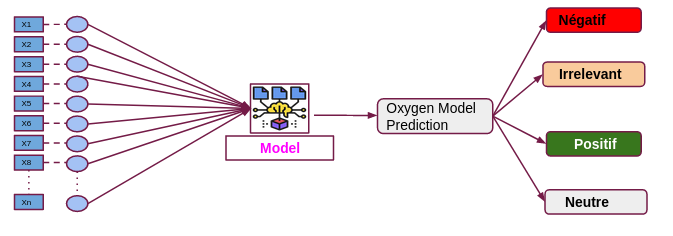
###### Dans cette architecture on a un seul model pour predire les quatre Classe 

In [86]:
Y = df['feeling_detected']
X = df.drop ('feeling_detected'  , axis = 1)
X.head()

,ID,Company,Tweet_text,tweet_text_length,Langue
0,0000,0,number min line store pump,7,1
1,0001,2,nueva tecnologa conviert cualquier superfici e...,12,0
2,0002,1,some peopl should not post repli googl thread ...,17,1
3,0003,0,know few other same issu number second full ch...,22,1
4,0004,2,microsoft put backward into backward compat in...,10,1


In [87]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=42) # split les données

In [88]:
Vectorizer = CountVectorizer(ngram_range = (1,2), analyzer='word', max_features=800 ) ## Count vectorizer 

In [89]:
X_train_vectorized = Vectorizer.fit_transform(X_train['Tweet_text']) 
X_train_vectorized =X_train_vectorized.toarray()

In [90]:
features = Vectorizer.get_feature_names()
print((features))

['account', 'actual', 'ad', 'add', 'addict', 'after', 'again', 'against', 'age', 'age number', 'ah', 'ahora', 'al', 'al twitter', 'alreadi', 'also', 'alway', 'am', 'amaz', 'analyt', 'android', 'android beam', 'android googl', 'android ic', 'android icecreamsandwich', 'android microsoft', 'android number', 'android phone', 'android samsung', 'androidnumb', 'ani', 'announc', 'anoth', 'anyon', 'app', 'app pampershelloapp', 'appl', 'appl googl', 'appl microsoft', 'appl store', 'appli', 'aqui', 'articl', 'asia', 'asia googl', 'asiaclassifiedtoday', 'ask', 'ass', 'auf', 'augnl', 'autopilot', 'autopilot let', 'autopilot numberaday', 'avail', 'avec', 'away', 'awesom', 'azur', 'babi', 'babi memori', 'back', 'bad', 'ballmer', 'bar', 'batteri', 'beam', 'beat', 'becaus', 'been', 'befor', 'best', 'better', 'between', 'bien', 'big', 'bij', 'bill', 'bill gate', 'bing', 'bit', 'blog', 'book', 'bookca', 'both', 'bought', 'bring', 'buena', 'bueno', 'build', 'busi', 'but', 'buy', 'buy yahoo', 'buzz', 'ca

In [91]:
df_train = pd.DataFrame(X_train_vectorized,columns=features) 

In [92]:
## Ajouter les features de reference au train set à savoir 'langue' ,'Company' , 'tweet_text_length'
X_test_langue_train = list(X_train['Langue'])
X_test_Company_train= list(X_train['Company'])
X_test_tweet_text_length_train= list(X_train['tweet_text_length'])

df_train['Langue'] =X_test_langue_train
df_train['Company'] =  X_test_Company_train
df_train['tweet_text_length'] =  X_test_tweet_text_length_train

In [93]:
# Fonction pour supprimer les mot qui apparaissent moin de n fois, le n est determiné par le parametre seuil
def clean_df_by_frequence (df , seuil = 1) : 
    res = []
    for col in df.columns :
        if df[col].sum() <= seuil : 
            res.append(col)
    return res

col_to_drop = clean_df_by_frequence(df_train,seuil = 2)
df_train.drop(col_to_drop , axis = 1 , inplace= True)

In [94]:
df_train.head()

,account,actual,ad,add,addict,after,again,against,age,age number,...,yahoo,year,year number,yet,yo,youtub,zijn,Langue,Company,tweet_text_length
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,1,8
1,0,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,1,2,26
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,1,7
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,3,12
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,8


In [95]:
## Ensemble de test
X_test_vectorized = Vectorizer.transform(X_test['Tweet_text'])
X_test_vectorized = X_test_vectorized.toarray()

In [96]:
X_test_langue_test = list(X_test['Langue'])
X_test_Company_test= list(X_test['Company'])
X_test_tweet_text_length_test= list(X_test['tweet_text_length'])

df_test = pd.DataFrame(X_test_vectorized,columns=features)
df_test['Langue'] = X_test_langue_test
df_test['Company'] =  X_test_Company_test
df_test['tweet_text_length'] =  X_test_tweet_text_length_test

In [97]:
df_test.drop(col_to_drop , axis = 1 , inplace= True)

In [98]:
df_test.head()

,account,actual,ad,add,addict,after,again,against,age,age number,...,yahoo,year,year number,yet,yo,youtub,zijn,Langue,Company,tweet_text_length
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,1,16
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,6
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,2,18
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,3,5
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,5


#### MRMR
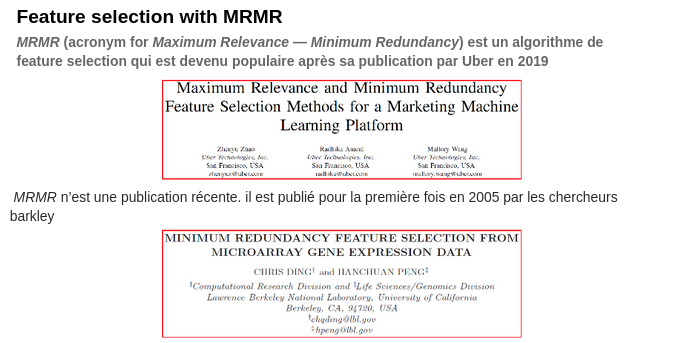


In [99]:
from mrmr import mrmr_classif

In [102]:
selected_features = mrmr_classif(X= df_train, y=y_train, K=18)

In [103]:
print(selected_features)

['excit', 'shit', 'hate', 'fail', 'amaz', 'crash', 'eclips', 'sinc', 'devic microsoft', 'googl nexus', 'sound', 'cant wait', 'fuck', 'doesnt', 'final', 'troubl', 'piss', 'love']


on a pas appliquer ce traitement car ça n'améliore pas notre score en revanche notre model est beaucoup plus simple

##### Multi layer perceptron

In [104]:
clf = MLPClassifier(activation = 'tanh',alpha=1e-6,batch_size=32,  solver ='adam' ,hidden_layer_sizes=(32,16), random_state=1,max_iter= 4)
clf.fit(df_train, y_train)
y_pred = clf.predict(df_test)
print("Accuracy  : " ,accuracy_score(y_pred,y_test))
print("F1_Score  : " ,   f1_score(y_test, y_pred, average='weighted'))

y_pred = clf.predict(df_train)
print("Accuracy_Train  : " ,accuracy_score(y_pred,y_train))
print("F1_Score_Train  : " ,   f1_score(y_train, y_pred, average='weighted'))

Accuracy  :  0.7772455089820359
F1_Score  :  0.7716131199434848
Accuracy_Train  :  0.8466147393648892
F1_Score_Train  :  0.8437784968577559


##### SVM 

In [105]:
# entrainemet
from sklearn import svm
clf = svm.SVC(75,kernel = 'rbf' ) 
clf.fit(df_train, y_train)
y_pred = clf.predict(df_test)
print("Accuracy  : " ,accuracy_score(y_pred,y_test))
print("F1_Score  : " ,   f1_score(y_test, y_pred, average='weighted'))

y_pred = clf.predict(df_train)
print("Accuracy_Train  : " ,accuracy_score(y_pred,y_train))
print("F1_Score_Train  : " ,   f1_score(y_train, y_pred, average='weighted'))

Accuracy  :  0.7772455089820359
F1_Score  :  0.7716185599021596
Accuracy_Train  :  0.9170161773517076
F1_Score_Train  :  0.9163566378717217


##### Random Forest

In [106]:
clf = RandomForestClassifier(max_depth=44, random_state=0,max_features = "sqrt",criterion ='entropy')
clf.fit(df_train, y_train)
y_pred = clf.predict(df_test)
print("Accuracy_Test  : " ,accuracy_score(y_pred,y_test))
print("F1_Score_Test  : " ,   f1_score(y_test, y_pred, average='weighted'))

y_pred = clf.predict(df_train)
print("Accuracy_Train  : " ,accuracy_score(y_pred,y_train))
print("F1_Score_Train  : " ,   f1_score(y_train, y_pred, average='weighted'))

Accuracy_Test  :  0.7473053892215569
F1_Score_Test  :  0.7061643768632709
Accuracy_Train  :  0.914319952067106
F1_Score_Train  :  0.9132382774828588


##  Conception Du Model Architecture 01 
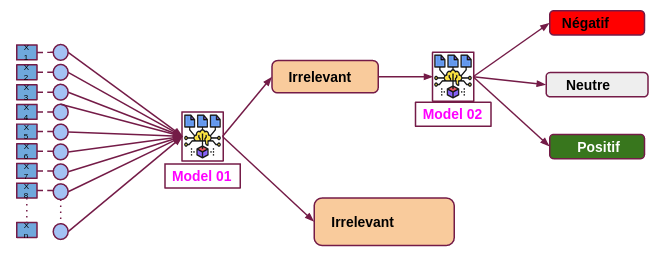
###### Dans cette architecture on a deux model :
        ° le premier pour separer les relevant et irrelevant 
        ° le deuxieme pour separer les positifs, negatifs et neutres 

#### Partie I

In [111]:
Y = df['feeling_detected']
X = df.drop ('feeling_detected'  , axis = 1)
X.head()

,ID,Company,Tweet_text,tweet_text_length,Langue
0,0000,0,number min line store pump,7,1
1,0001,2,nueva tecnologa conviert cualquier superfici e...,12,0
2,0002,1,some peopl should not post repli googl thread ...,17,1
3,0003,0,know few other same issu number second full ch...,22,1
4,0004,2,microsoft put backward into backward compat in...,10,1


In [112]:
## Création de la nouvelle cible avec deux Class : irr and not_irr
Y_new  = []
for x in Y : 
    if x == 'irr' : 
        Y_new.append('irr')
    else : 
        Y_new.append('not_irr')

In [113]:
X_train, X_test, y_train, y_test = train_test_split(X, Y_new, test_size=0.2, random_state=42)

In [114]:
Vectorizer = CountVectorizer(ngram_range = (1,2), analyzer='word' , max_features= 500)

In [115]:
X_train_vectorized = Vectorizer.fit_transform(X_train['Tweet_text'])
X_train_vectorized =X_train_vectorized.toarray()

In [117]:
features = Vectorizer.get_feature_names()

In [119]:
df_train = pd.DataFrame(X_train_vectorized,columns=features)

X_test_langue_train = list(X_train['Langue'])
X_test_Company_train= list(X_train['Company'])
X_test_tweet_text_length_train= list(X_train['tweet_text_length'])

df_train['Langue'] =X_test_langue_train
df_train['Company'] =  X_test_Company_train
df_train['tweet_text_length'] =  X_test_tweet_text_length_train

col_to_drop = clean_df_by_frequence(df_train)
df_train.drop(col_to_drop , axis = 1 , inplace= True)

In [120]:
X_test_vectorized = Vectorizer.transform(X_test['Tweet_text'])
X_test_vectorized = X_test_vectorized.toarray()

In [122]:
df_test = pd.DataFrame(X_test_vectorized,columns=features) 

X_test_langue_test = list(X_test['Langue'])
X_test_Company_test= list(X_test['Company'])
X_test_tweet_text_length_test= list(X_test['tweet_text_length'])

df_test['Langue'] = X_test_langue_test
df_test['Company'] =  X_test_Company_test
df_test['tweet_text_length'] =  X_test_tweet_text_length_test

df_test.drop(col_to_drop , axis = 1 , inplace= True)

##### MLPClassifier

In [129]:
clf = MLPClassifier(activation = 'relu',alpha=1e-12, solver ='adam' ,hidden_layer_sizes=(32,16), random_state=1,max_iter= 14)
clf.fit(df_train, y_train)
y_pred = clf.predict(df_test)
print("Accuracy  : " ,accuracy_score(y_pred,y_test))
print("F1_Score  : " ,   f1_score(y_test, y_pred, average='weighted'))

y_pred = clf.predict(df_train)
print("Accuracy_Train  : " ,accuracy_score(y_pred,y_train))
print("F1_Score_Train  : " ,   f1_score(y_train, y_pred, average='weighted'))

Accuracy  :  0.9269461077844311
F1_Score  :  0.9266212767761854
Accuracy_Train  :  0.9418813660874775
F1_Score_Train  :  0.9416669139334043


#### svm

In [130]:
# entrainemet
from sklearn import svm
clf = svm.SVC(15,kernel = 'rbf' ) 
clf.fit(df_train, y_train)
y_pred = clf.predict(df_test)
print("Accuracy  : " ,accuracy_score(y_pred,y_test))
print("F1_Score  : " ,   f1_score(y_test, y_pred, average='weighted'))

y_pred = clf.predict(df_train)
print("Accuracy_Train  : " ,accuracy_score(y_pred,y_train))
print("F1_Score_Train  : " ,   f1_score(y_train, y_pred, average='weighted'))

Accuracy  :  0.9137724550898204
F1_Score  :  0.9130700229853935
Accuracy_Train  :  0.9286998202516477
F1_Score_Train  :  0.9279686250346125


### Partie II

In [133]:
df_rest = df[df['feeling_detected'] != 'irr']

In [134]:
Y = df_rest['feeling_detected']
X = df_rest.drop ('feeling_detected'  , axis = 1)
X.head()

,ID,Company,Tweet_text,tweet_text_length,Langue
0,0000,0,number min line store pump,7,1
2,0002,1,some peopl should not post repli googl thread ...,17,1
3,0003,0,know few other same issu number second full ch...,22,1
4,0004,2,microsoft put backward into backward compat in...,10,1
5,0005,3,twitter sooo trash ritenow dezz highscoolmemori,10,1


In [137]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

In [162]:
Vectorizer = CountVectorizer(ngram_range = (1,2), analyzer='word', max_features= 800)

In [163]:
X_train_vectorized = Vectorizer.fit_transform(X_train['Tweet_text'])
X_train_vectorized =X_train_vectorized.toarray()

In [164]:
features = Vectorizer.get_feature_names()

In [165]:
df_train = pd.DataFrame(X_train_vectorized,columns=features)

X_test_langue_train = list(X_train['Langue'])
X_test_Company_train= list(X_train['Company'])
X_test_tweet_text_length_train= list(X_train['tweet_text_length'])

df_train['Langue'] =X_test_langue_train
df_train['Company'] =  X_test_Company_train
df_train['tweet_text_length'] =  X_test_tweet_text_length_train

col_to_drop = clean_df_by_frequence(df_train)
df_train.drop(col_to_drop , axis = 1 , inplace= True)

In [166]:
X_test_vectorized = Vectorizer.transform(X_test['Tweet_text'])
X_test_vectorized = X_test_vectorized.toarray()

In [167]:
df_test = pd.DataFrame(X_test_vectorized,columns=features) 

X_test_langue_test = list(X_test['Langue'])
X_test_Company_test= list(X_test['Company'])
X_test_tweet_text_length_test= list(X_test['tweet_text_length'])

df_test['Langue'] = X_test_langue_test
df_test['Company'] =  X_test_Company_test
df_test['tweet_text_length'] =  X_test_tweet_text_length_test

df_test.drop(col_to_drop , axis = 1 , inplace= True)

In [168]:
##### MLPClassifier

In [178]:
clf = MLPClassifier(activation = 'tanh',alpha=1e-6,batch_size=32 ,  solver ='adam' ,hidden_layer_sizes=(32,16), random_state=1,max_iter=7)
clf.fit(df_train, y_train)
y_pred = clf.predict(df_test)
print("Accuracy  : " ,accuracy_score(y_pred,y_test))
print("F1_Score  : " ,   f1_score(y_test, y_pred, average='weighted'))

y_pred = clf.predict(df_train)
print("Accuracy_Train  : " ,accuracy_score(y_pred,y_train))
print("F1_Score_Train  : " ,   f1_score(y_train, y_pred, average='weighted'))

Accuracy  :  0.7307001795332136
F1_Score  :  0.7235006506539364
Accuracy_Train  :  0.9012123933542883
F1_Score_Train  :  0.9012119807394356


In [175]:
# entrainemet
from sklearn import svm
clf = svm.SVC(75,kernel = 'rbf' ) 
clf.fit(df_train, y_train)
y_pred = clf.predict(df_test)
print("Accuracy  : " ,accuracy_score(y_pred,y_test))
print("F1_Score  : " ,   f1_score(y_test, y_pred, average='weighted'))

y_pred = clf.predict(df_train)
print("Accuracy_Train  : " ,accuracy_score(y_pred,y_train))
print("F1_Score_Train  : " ,   f1_score(y_train, y_pred, average='weighted'))

Accuracy  :  0.7199281867145422
F1_Score  :  0.6973853662458244
Accuracy_Train  :  0.9389312977099237
F1_Score_Train  :  0.9372350046885557
